<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asymmetric Noise 10%</h3>

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [5]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.1
loss_function = 'DampedSCELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedSCELoss_aircrafts_asym_0.1_0.25_baseline
Model Features: DampedSCELoss_aircrafts_asym_0.1_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedSCELoss_aircrafts_asym_0.1_0.25
Csv save: DampedSCELoss_aircrafts_asym_0.1_0.25
Saving features from Scheme delta = 0.25: DampedSCELoss_aircrafts_asym_0.1_0.5
Saving csv for damp_2: DampedSCELoss_aircrafts_asym_0.1_0.5


# Declaration of models Net family with Resolution, Epochs, and Batch size

In [6]:
architecture = 'efficientnet-b4'

effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [7]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

Filepath  Noisy_labels  Label  Label_numeric
0      aircrafts_original/0/0716386.jpg             1      0              0
1      aircrafts_original/0/0810608.jpg             1      0              0
2      aircrafts_original/0/1427680.jpg             1      0              0
3      aircrafts_original/0/1017179.jpg             1      0              0
4      aircrafts_original/0/0536721.jpg             1      0              0
...                                 ...           ...    ...            ...
6662  aircrafts_original/99/1117057.jpg            99     99             99
6663  aircrafts_original/99/1026133.jpg            99     99             99
6664  aircrafts_original/99/0730106.jpg            99     99             99
6665  aircrafts_original/99/1801242.jpg            99     99             99
6666  aircrafts_original/99/0944239.jpg            99     99             99

[6667 rows x 4 columns]

In [8]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

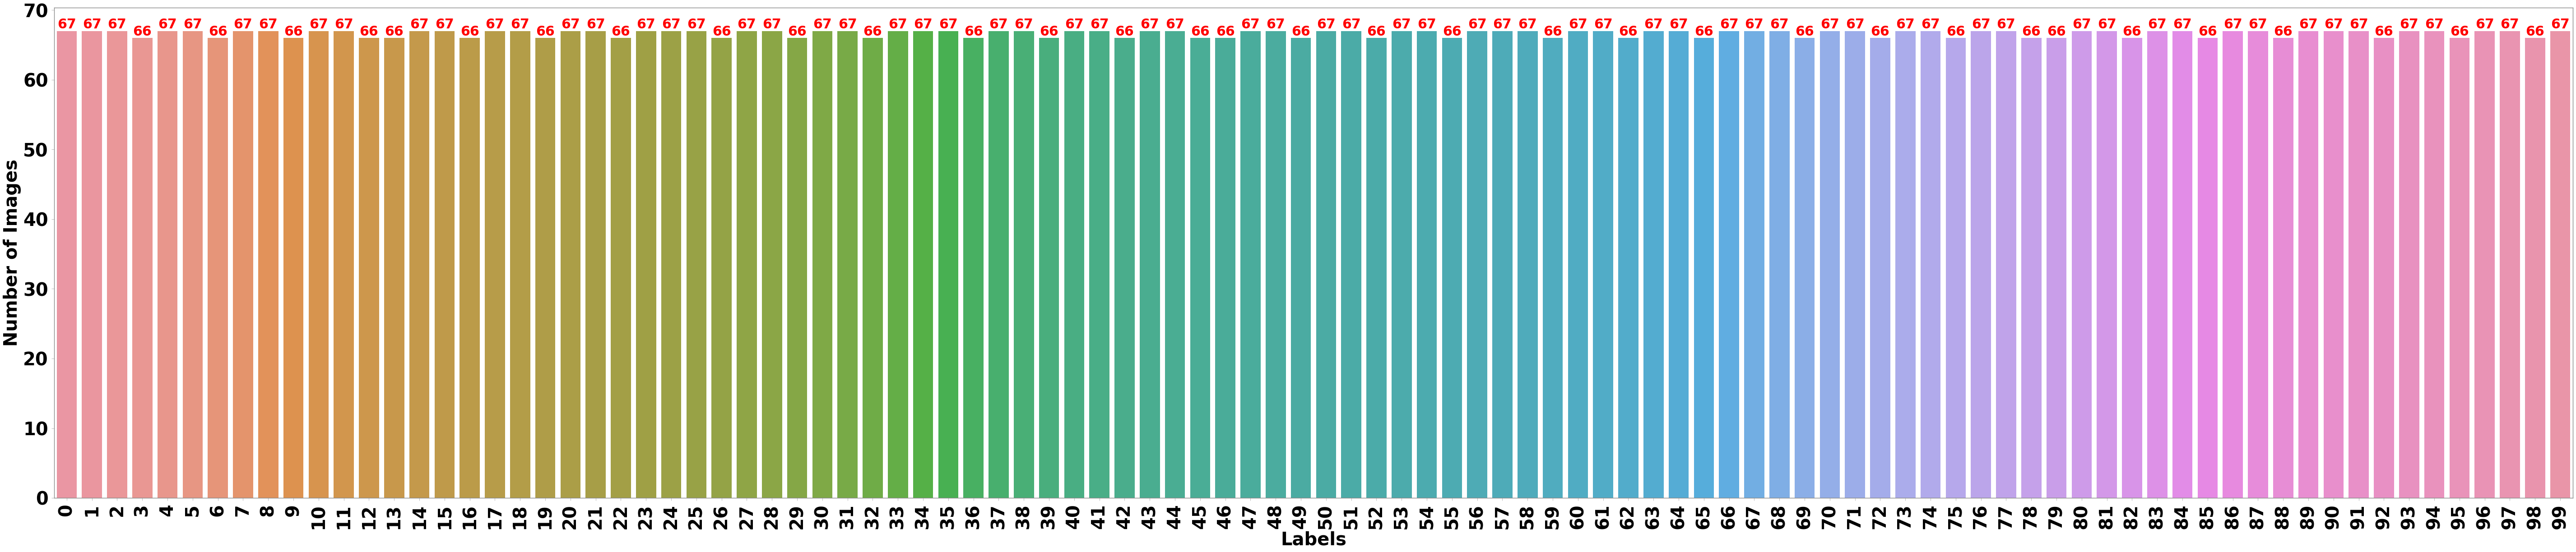

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [10]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [11]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

Filepath Label
0     testing/65/1943358.jpg    65
1     testing/65/1088603.jpg    65
2     testing/65/1714026.jpg    65
3     testing/65/1806208.jpg    65
4     testing/65/1759298.jpg    65
...                      ...   ...
3328  testing/80/0606801.jpg    80
3329  testing/80/1088415.jpg    80
3330  testing/80/1455400.jpg    80
3331  testing/80/1686317.jpg    80
3332  testing/80/2180164.jpg    80

[3333 rows x 2 columns]

In [12]:
test_df['Label'] = test_df['Label'].map(lambda x: x.lower())

In [13]:
sorted_df = test_df.sort_values(by='Label').reset_index(drop=True)
sorted_df

Filepath Label
0      testing/0/1191359.jpg     0
1      testing/0/0447936.jpg     0
2      testing/0/0658110.jpg     0
3      testing/0/0064932.jpg     0
4      testing/0/0717480.jpg     0
...                      ...   ...
3328  testing/99/1616362.jpg    99
3329  testing/99/0784557.jpg    99
3330  testing/99/1176955.jpg    99
3331  testing/99/1544178.jpg    99
3332  testing/99/1885835.jpg    99

[3333 rows x 2 columns]

In [11]:
my_list = sorted_df.Label.unique()

In [12]:
my_dict = {value: index for index, value in enumerate(my_list)}

In [13]:
sorted_df['Label_numeric'] = sorted_df['Label'].map(my_dict)
sorted_df

Filepath Label  Label_numeric
0      testing/0/0789828.jpg     0              0
1      testing/0/1453508.jpg     0              0
2      testing/0/0895165.jpg     0              0
3      testing/0/0536515.jpg     0              0
4      testing/0/0747566.jpg     0              0
...                      ...   ...            ...
3328  testing/99/0973160.jpg    99             99
3329  testing/99/0197892.jpg    99             99
3330  testing/99/1176955.jpg    99             99
3331  testing/99/1298910.jpg    99             99
3332  testing/99/0725715.jpg    99             99

[3333 rows x 3 columns]

In [14]:
test_df = sorted_df[['Filepath', 'Label_numeric', 'Label']]
test_df

Filepath  Label_numeric Label
0      testing/0/0789828.jpg              0     0
1      testing/0/1453508.jpg              0     0
2      testing/0/0895165.jpg              0     0
3      testing/0/0536515.jpg              0     0
4      testing/0/0747566.jpg              0     0
...                      ...            ...   ...
3328  testing/99/0973160.jpg             99    99
3329  testing/99/0197892.jpg             99    99
3330  testing/99/1176955.jpg             99    99
3331  testing/99/1298910.jpg             99    99
3332  testing/99/0725715.jpg             99    99

[3333 rows x 3 columns]

In [15]:
label_counts = sorted_df['Label_numeric'].value_counts().sort_index().tolist()
print(label_counts)

[33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33]


In [16]:
labels = sorted_df.Label_numeric.tolist()
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

Text(0, 0.5, 'Number of Images')

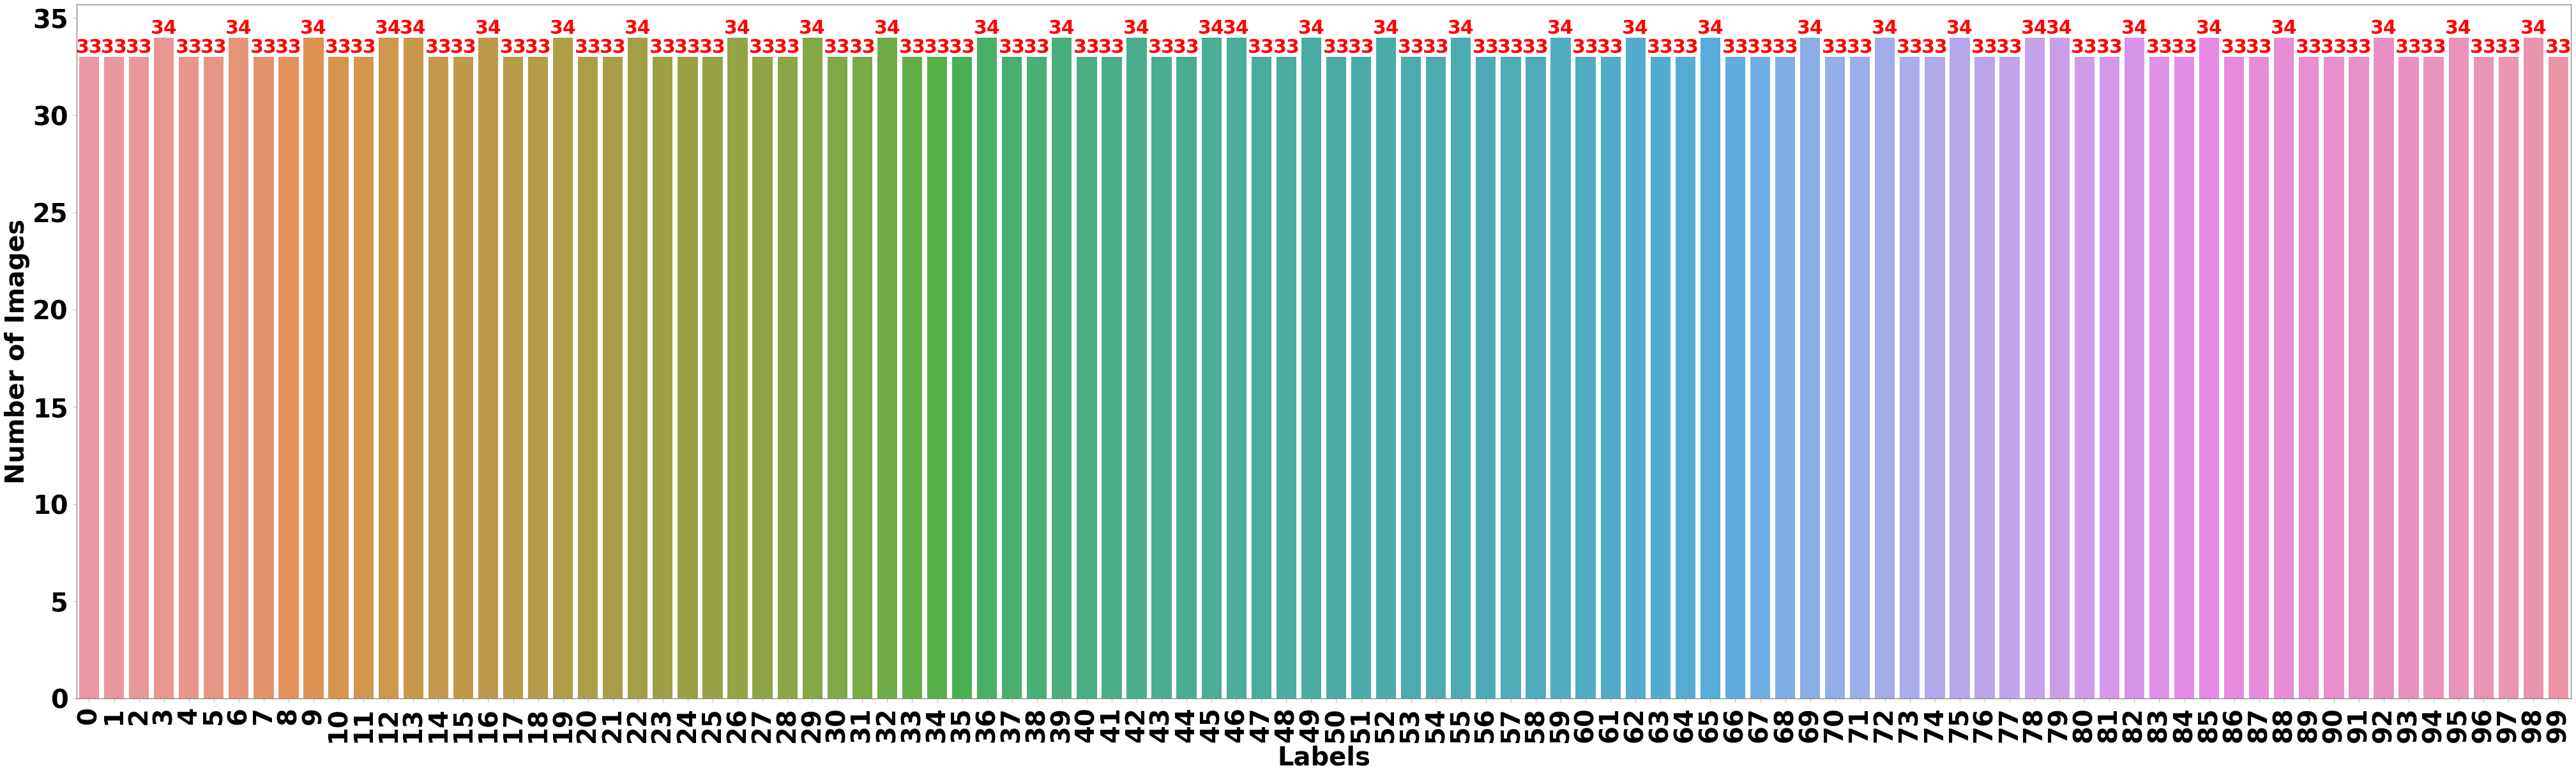

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [21]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [22]:
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


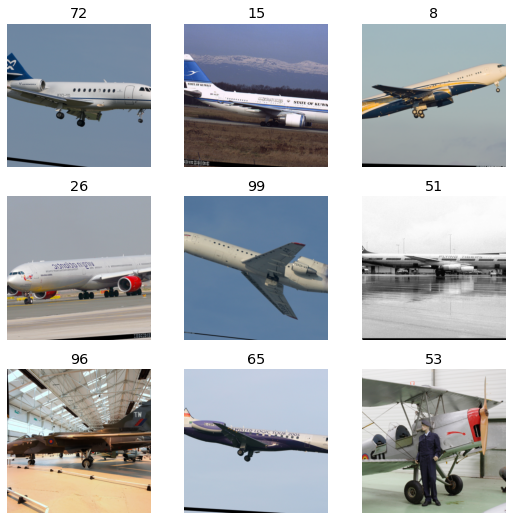

In [23]:
data0.show_batch()

In [24]:
import damped_losses as losses
loss_func = losses.DampedSCELossFlat(num_classes=num_classes, alpha = 0.1, beta = 1.0, delta=0.0, reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [25]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= sce_aircrafts_asym_0.1_baseline


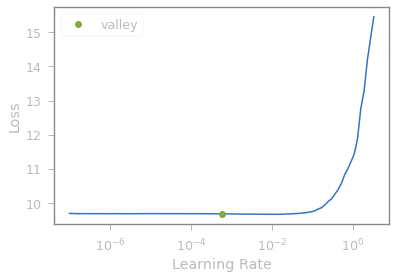

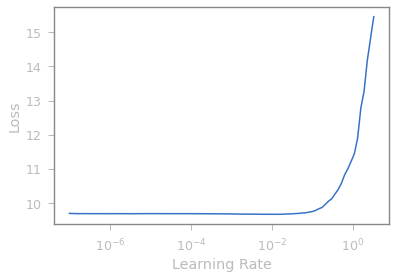

In [26]:
learn.lr_find()
learn.recorder.plot_lr_find()

Better model found at epoch 0 with accuracy value: 0.11402850598096848.


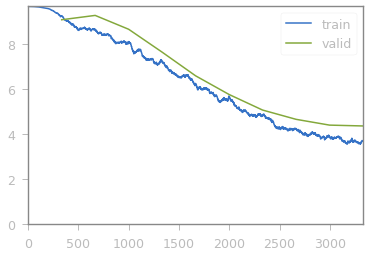

Better model found at epoch 1 with accuracy value: 0.1155288815498352.
Better model found at epoch 2 with accuracy value: 0.2250562608242035.
Better model found at epoch 3 with accuracy value: 0.36459115147590637.
Better model found at epoch 4 with accuracy value: 0.47411853075027466.
Better model found at epoch 5 with accuracy value: 0.5896474123001099.
Better model found at epoch 6 with accuracy value: 0.6661665439605713.
Better model found at epoch 7 with accuracy value: 0.7239309549331665.
Better model found at epoch 8 with accuracy value: 0.7381845712661743.
Better model found at epoch 9 with accuracy value: 0.7516879439353943.


In [27]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [28]:
learn.unfreeze()

Better model found at epoch 0 with accuracy value: 0.7539384961128235.


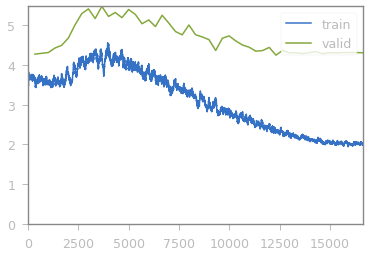

Better model found at epoch 36 with accuracy value: 0.7621905207633972.


In [29]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [30]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.8296)


In [31]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.8413)


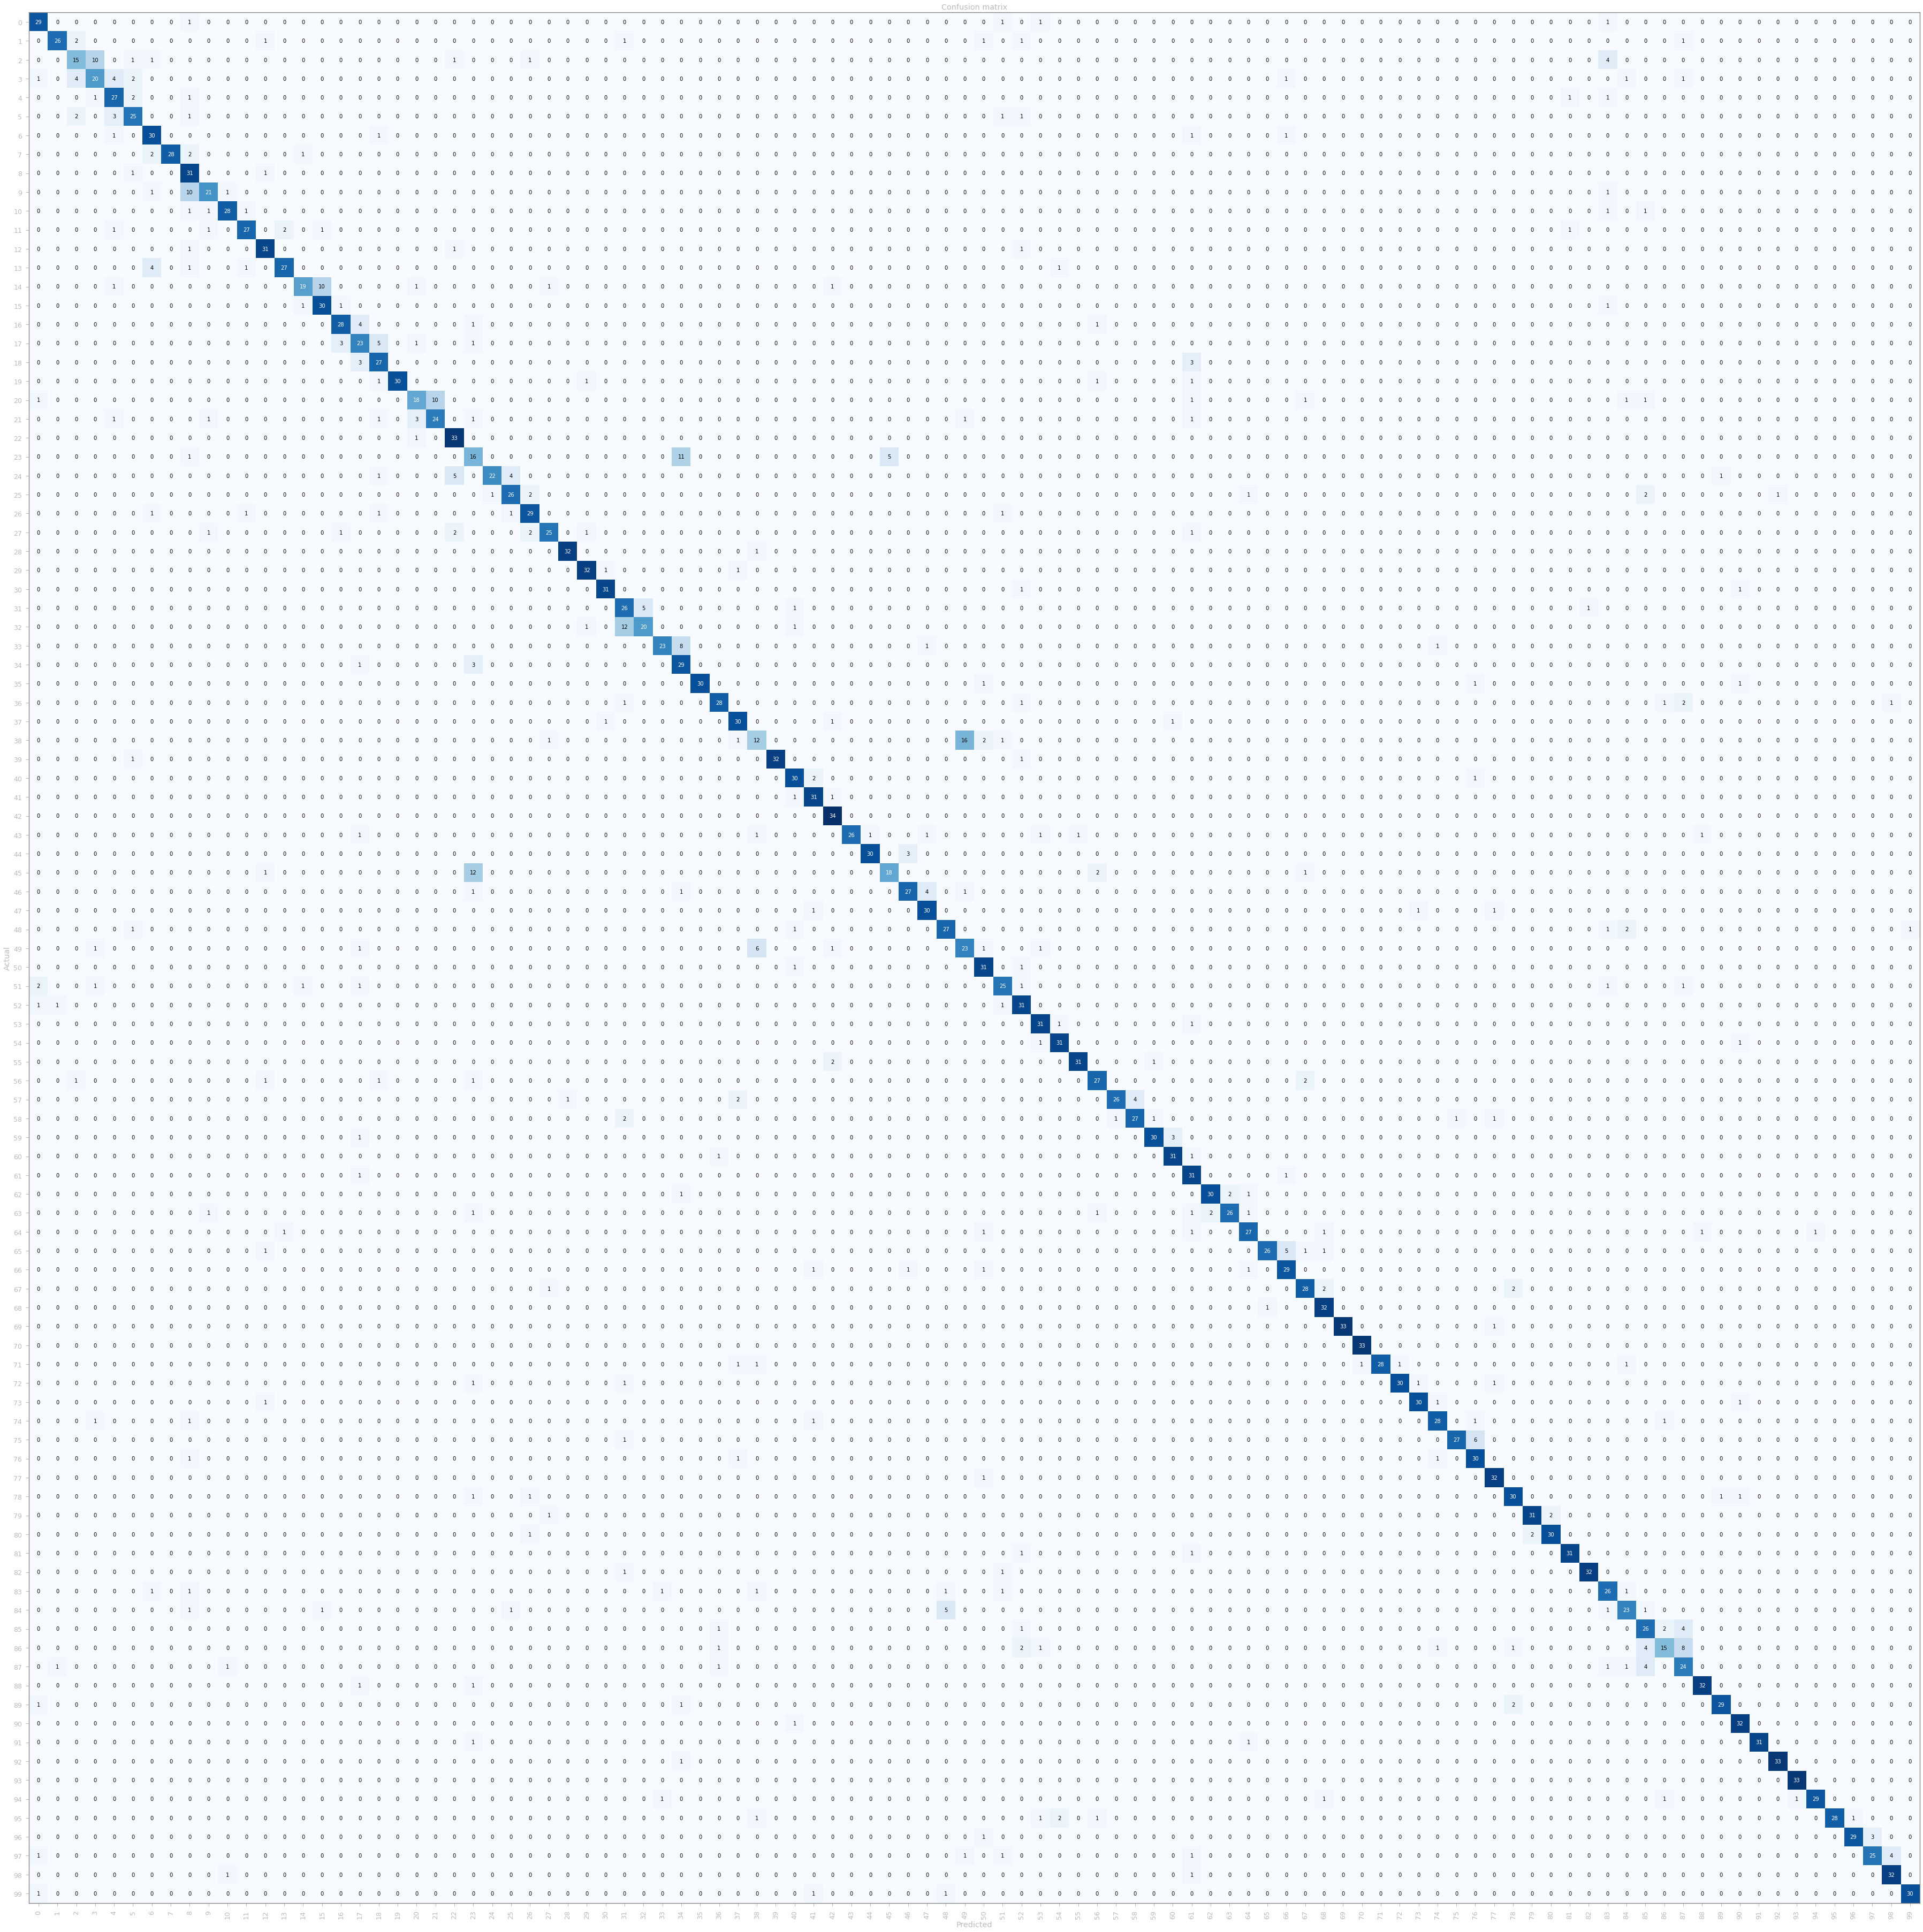

In [32]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [33]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [34]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/sce_aircrafts_asym_0.1_baseline.pth'

In [26]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering


def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,img_size,tfms,model,best_pth,k_samples=100, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered

# Dump 0.25 with Cleaning Scheme

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 82 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6585


Better model found at epoch 0 with accuracy value: 0.927107036113739.


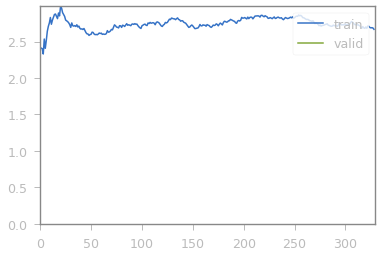

************Round:  0
TTA Accuracy:0.8520852327346802
cycle 0 Error Rate is [{0: (1.2299385030748455, 14.791476726531982)}]


+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 85 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6500


Better model found at epoch 0 with accuracy value: 0.9223076701164246.


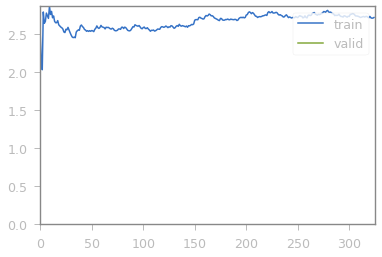

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 77 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6423


Better model found at epoch 0 with accuracy value: 0.9244548082351685.


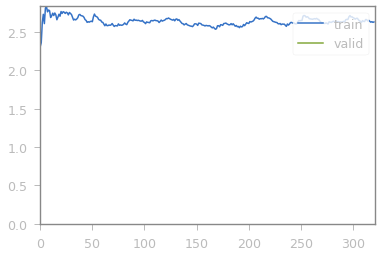

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 82 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6341


Better model found at epoch 0 with accuracy value: 0.9219242930412292.


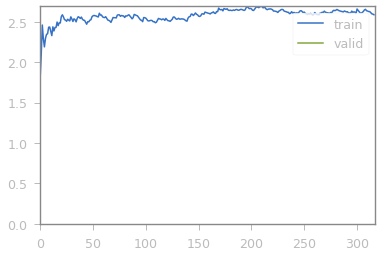

************Round:  3
TTA Accuracy:0.8604860305786133
cycle 0 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672)}]


+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 80 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6261


Better model found at epoch 0 with accuracy value: 0.9337060451507568.


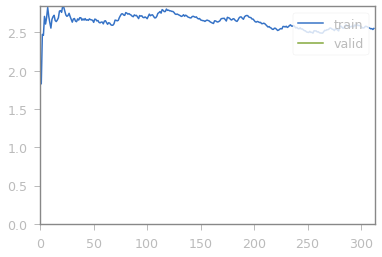

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 75 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6186


Better model found at epoch 0 with accuracy value: 0.9345189929008484.


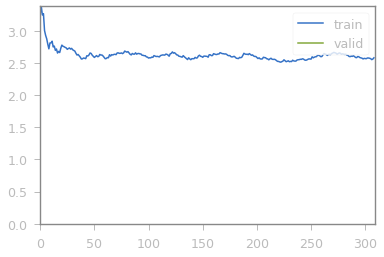

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 73 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6113


Better model found at epoch 0 with accuracy value: 0.9410802125930786.


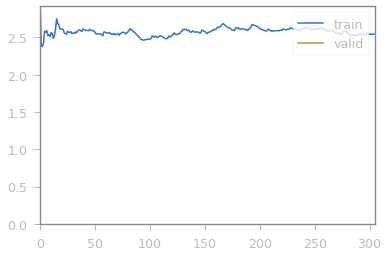

************Round:  6
TTA Accuracy:0.864086389541626
cycle 0 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402)}]


+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 74 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6039


Better model found at epoch 0 with accuracy value: 0.9428334832191467.


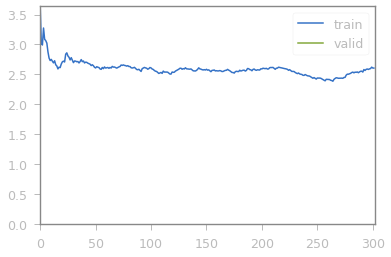

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 71 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5968


Better model found at epoch 0 with accuracy value: 0.945515513420105.


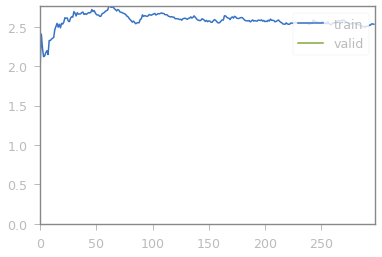

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 69 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5899


Better model found at epoch 0 with accuracy value: 0.9541984796524048.


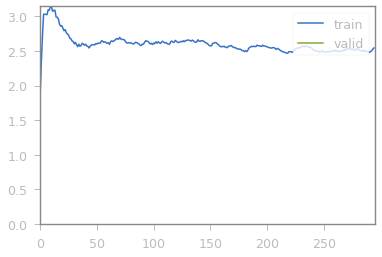

************Round:  9
TTA Accuracy:0.8622862100601196
cycle 0 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037)}]


+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 75 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5824


Better model found at epoch 0 with accuracy value: 0.9235395193099976.


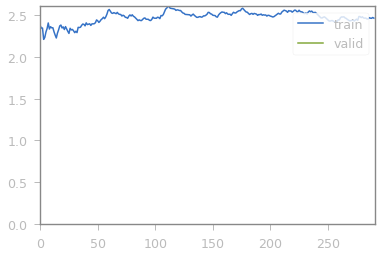

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 71 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5753


Better model found at epoch 0 with accuracy value: 0.9469565153121948.


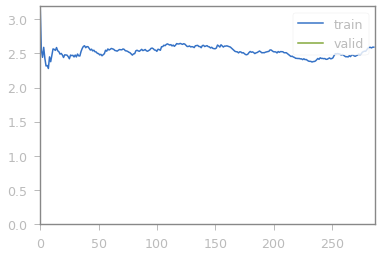

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 51
Min probability = 0.6954545454545454
Dropped 76 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5677


Better model found at epoch 0 with accuracy value: 0.9392070770263672.


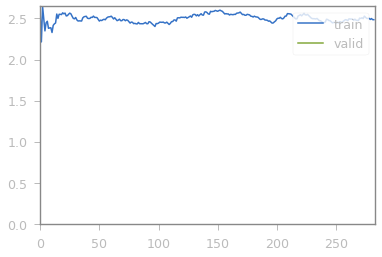

************Round:  12
TTA Accuracy:0.867986798286438
cycle 0 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037), 12: (14.84925753712314, 13.201320171356201)}]


+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 62 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5615


Better model found at epoch 0 with accuracy value: 0.9439002871513367.


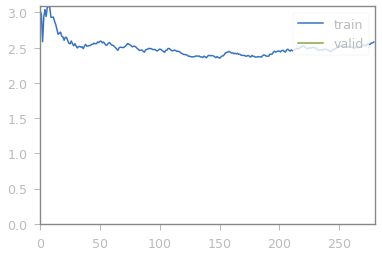

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 65
Min frequency is 48
Min probability = 0.6646153846153847
Dropped 54 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5561


Better model found at epoch 0 with accuracy value: 0.9505395889282227.


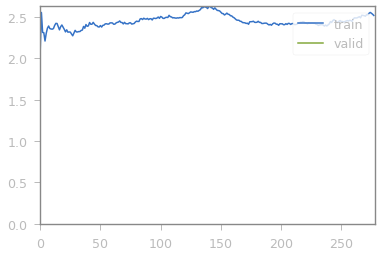

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 89 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6578


Better model found at epoch 0 with accuracy value: 0.9460076093673706.


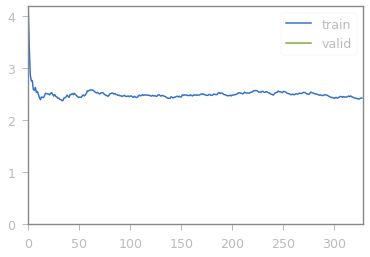

************Round:  0
TTA Accuracy:0.8715871572494507
cycle 1 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037), 12: (14.84925753712314, 13.201320171356201), 15: (1.3349332533373337, 12.841284275054932)}]


+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 80 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6498


Better model found at epoch 0 with accuracy value: 0.9507313370704651.


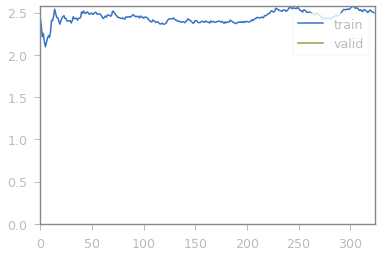

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 83 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6415


Better model found at epoch 0 with accuracy value: 0.9438815116882324.


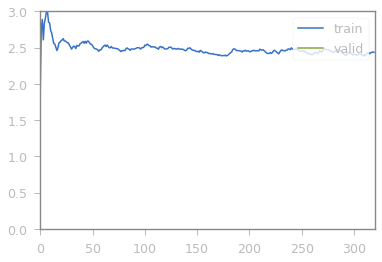

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 79 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6336


Better model found at epoch 0 with accuracy value: 0.9463298916816711.


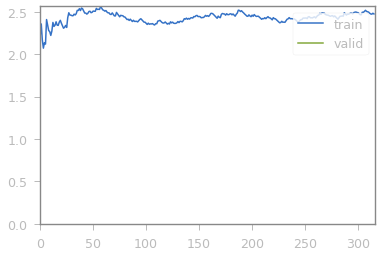

************Round:  3
TTA Accuracy:0.8736873865127563
cycle 1 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037), 12: (14.84925753712314, 13.201320171356201), 15: (1.3349332533373337, 12.841284275054932), 18: (4.964751762411879, 12.631261348724365)}]


+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 68 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6268


Better model found at epoch 0 with accuracy value: 0.9513168334960938.


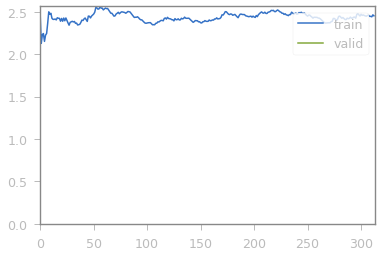

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 69 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6199


Better model found at epoch 0 with accuracy value: 0.9491525292396545.


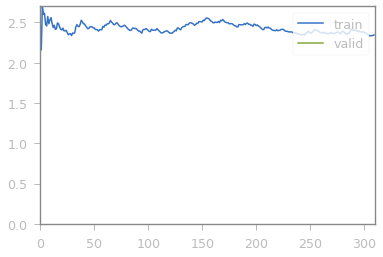

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 71 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6128


Better model found at epoch 0 with accuracy value: 0.9518367052078247.


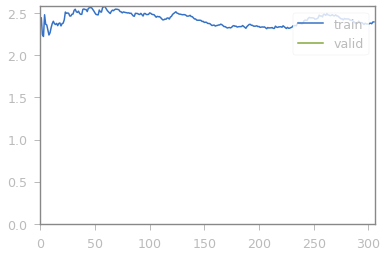

************Round:  6
TTA Accuracy:0.8712871074676514
cycle 1 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037), 12: (14.84925753712314, 13.201320171356201), 15: (1.3349332533373337, 12.841284275054932), 18: (4.964751762411879, 12.631261348724365), 21: (8.08459577021149, 12.871289253234863)}]


+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 65 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6063


Better model found at epoch 0 with accuracy value: 0.9562706351280212.


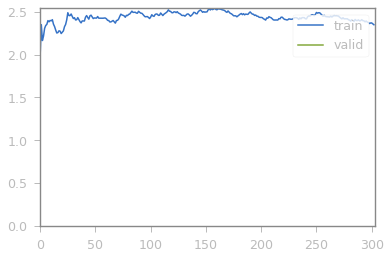

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 49
Min probability = 0.6681818181818182
Dropped 71 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5992


Better model found at epoch 0 with accuracy value: 0.9457429051399231.


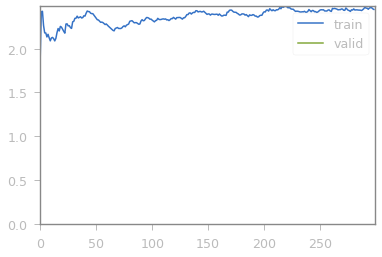

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 49
Min probability = 0.6681818181818182
Dropped 63 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5929


Better model found at epoch 0 with accuracy value: 0.945147693157196.


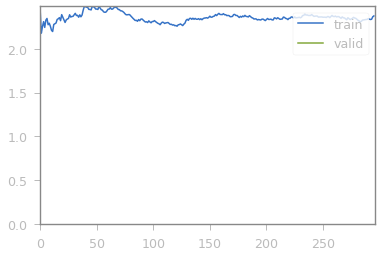

************Round:  9
TTA Accuracy:0.8670867085456848
cycle 1 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037), 12: (14.84925753712314, 13.201320171356201), 15: (1.3349332533373337, 12.841284275054932), 18: (4.964751762411879, 12.631261348724365), 21: (8.08459577021149, 12.871289253234863), 24: (11.069446527673621, 13.291329145431519)}]


+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 66
Min frequency is 46
Min probability = 0.6272727272727273
Dropped 62 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5867


Better model found at epoch 0 with accuracy value: 0.948849081993103.


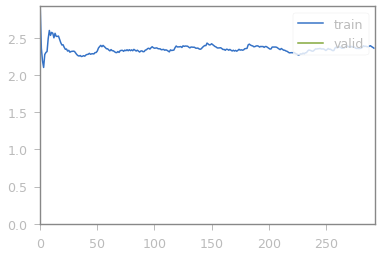

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 45
Min probability = 0.6136363636363636
Dropped 64 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5803


Better model found at epoch 0 with accuracy value: 0.949999988079071.


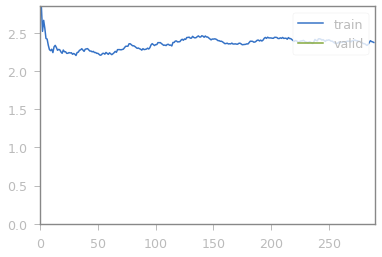

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 65
Min frequency is 44
Min probability = 0.6092307692307692
Dropped 55 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5748


Better model found at epoch 0 with accuracy value: 0.9512619376182556.


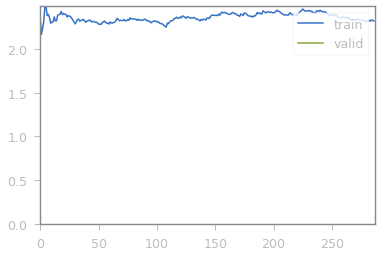

************Round:  12
TTA Accuracy:0.8682868480682373
cycle 1 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037), 12: (14.84925753712314, 13.201320171356201), 15: (1.3349332533373337, 12.841284275054932), 18: (4.964751762411879, 12.631261348724365), 21: (8.08459577021149, 12.871289253234863), 24: (11.069446527673621, 13.291329145431519), 27: (13.784310784460773, 13.17131519317627)}]


+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 41
Min probability = 0.5765625
Dropped 62 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5686


Better model found at epoch 0 with accuracy value: 0.9577836394309998.


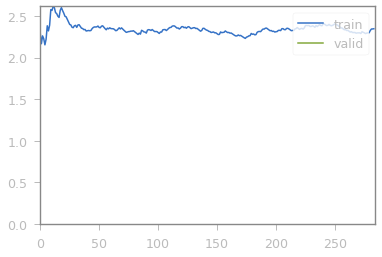

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 41
Min probability = 0.5857142857142857
Dropped 56 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5630


Better model found at epoch 0 with accuracy value: 0.9564831256866455.


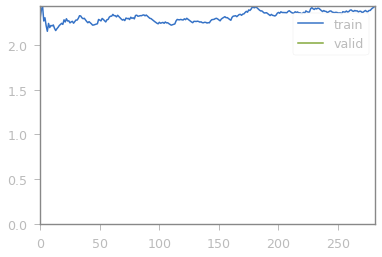

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 86 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6581


Better model found at epoch 0 with accuracy value: 0.9620060920715332.


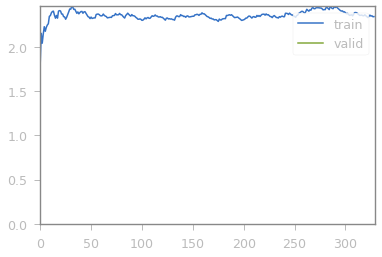

************Round:  0
TTA Accuracy:0.869486927986145
cycle 2 Error Rate is [{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037), 12: (14.84925753712314, 13.201320171356201), 15: (1.3349332533373337, 12.841284275054932), 18: (4.964751762411879, 12.631261348724365), 21: (8.08459577021149, 12.871289253234863), 24: (11.069446527673621, 13.291329145431519), 27: (13.784310784460773, 13.17131519317627), 30: (1.2899355032248372, 13.051307201385498)}]


+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 78 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6503


Better model found at epoch 0 with accuracy value: 0.9553846120834351.


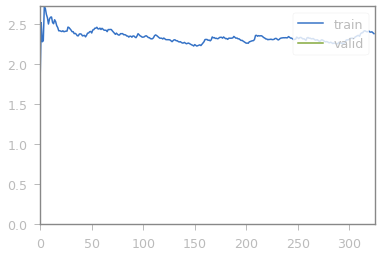

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 69 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6434


Better model found at epoch 0 with accuracy value: 0.9626749753952026.


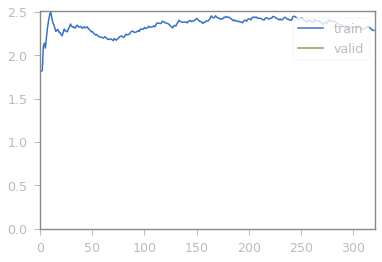

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 74 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6360


RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 10.75 GiB total capacity; 9.22 GiB already allocated; 21.19 MiB free; 9.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

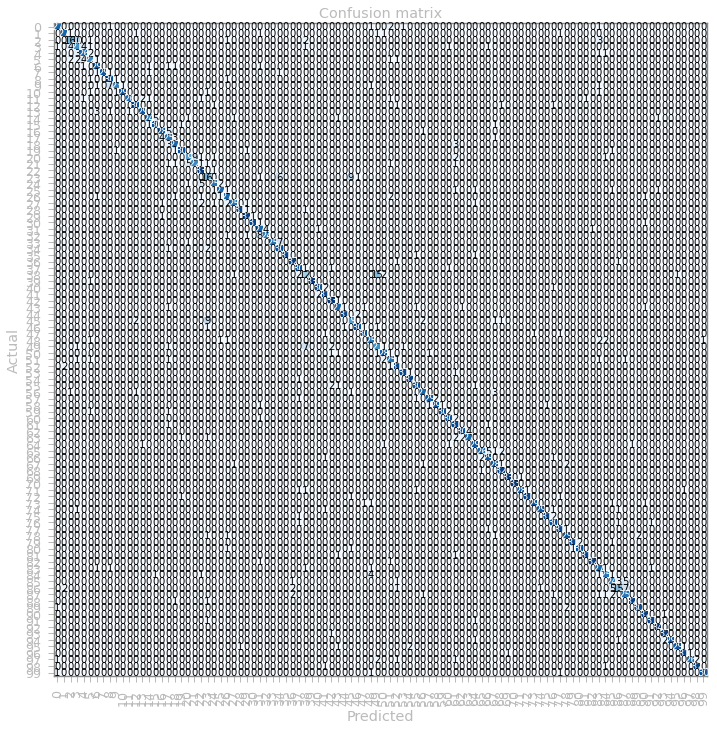

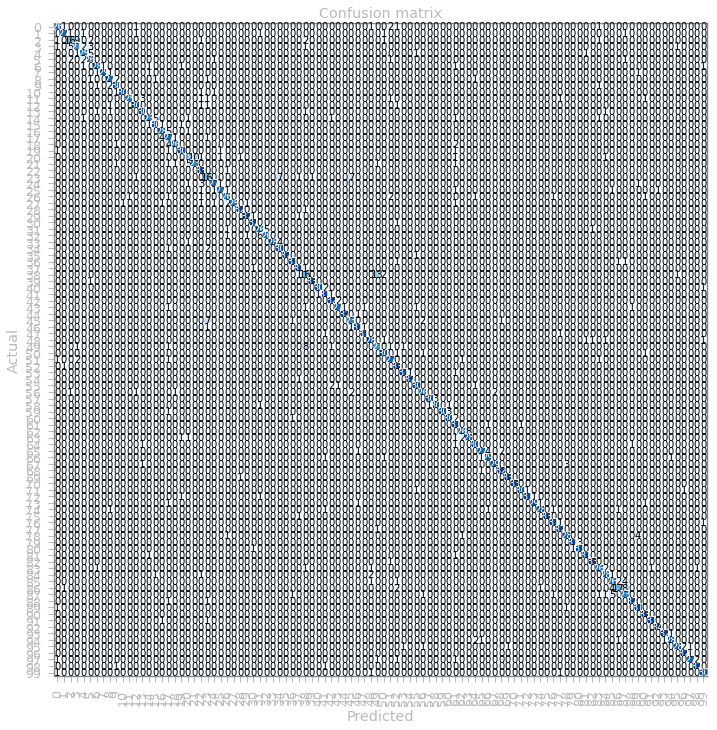

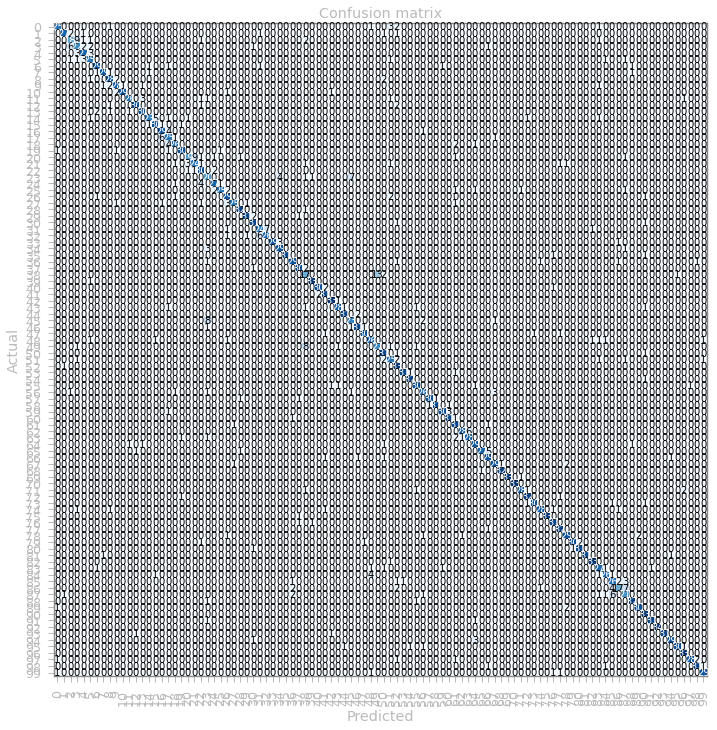

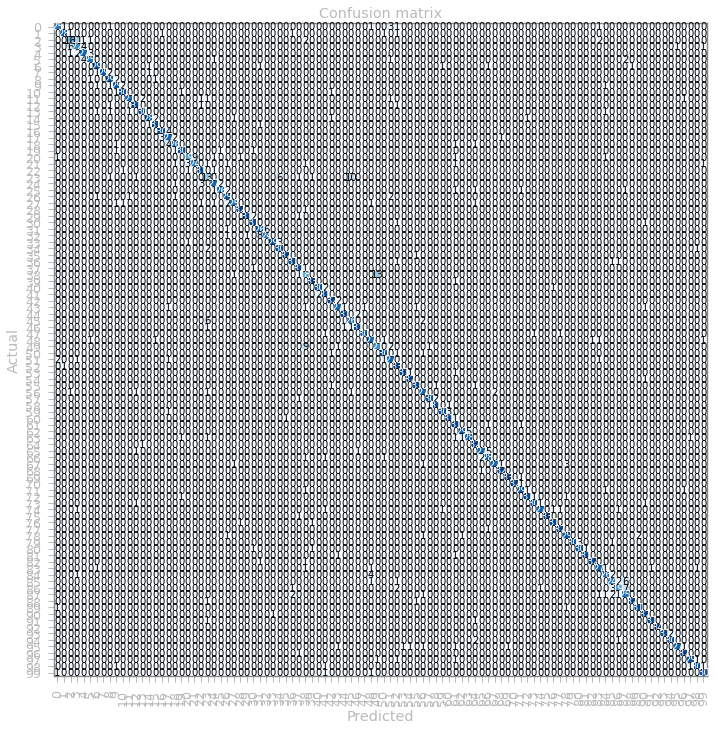

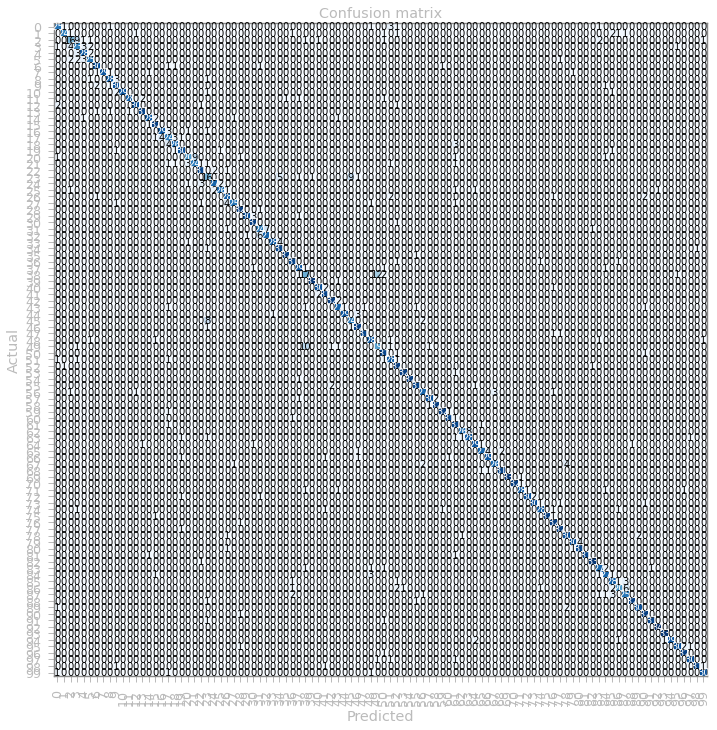

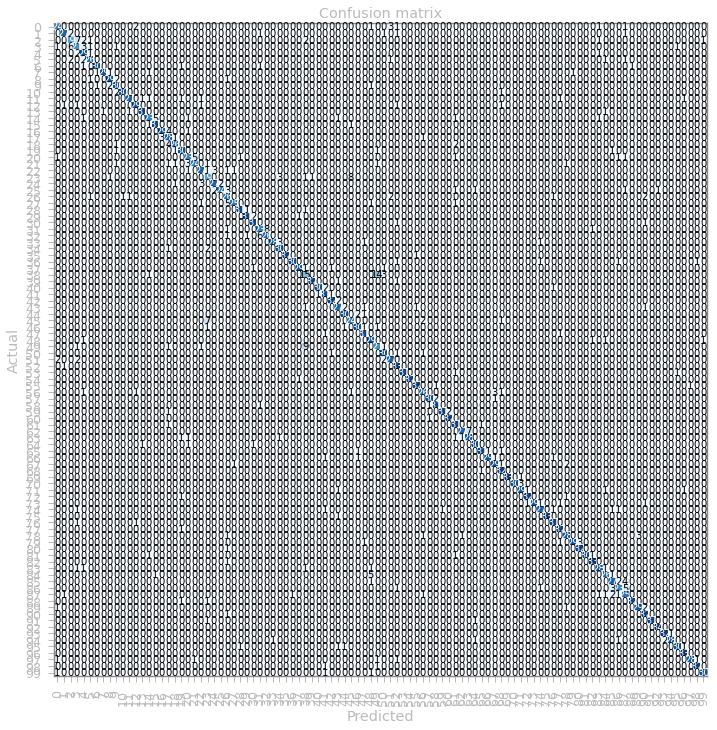

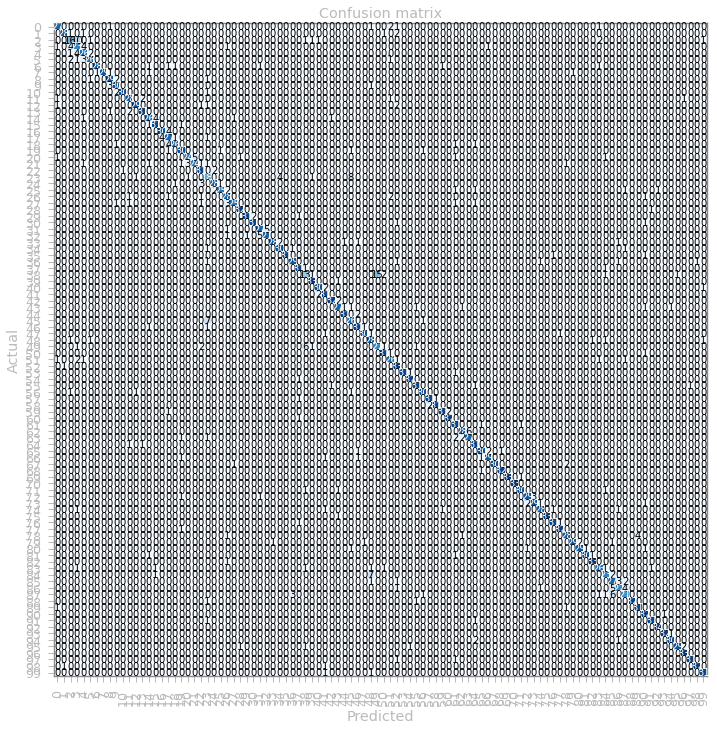

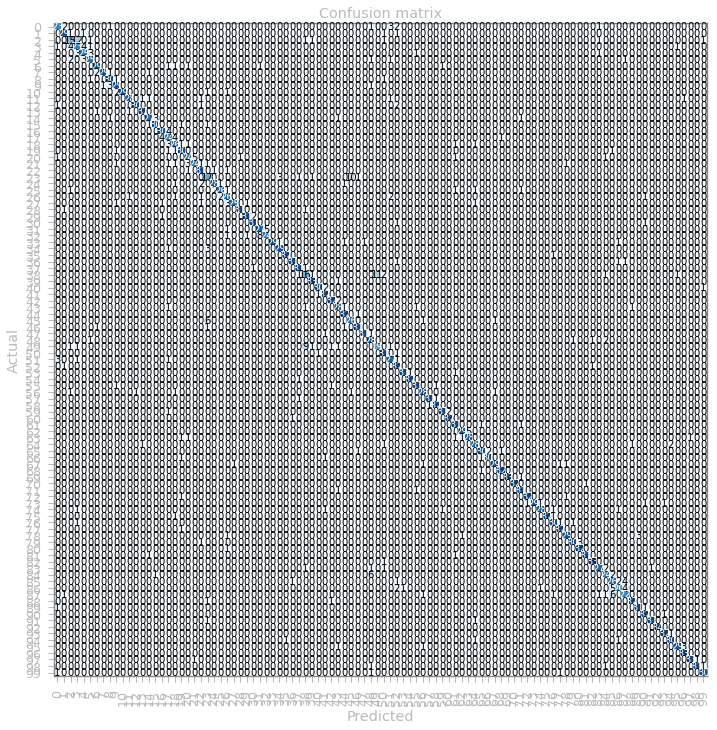

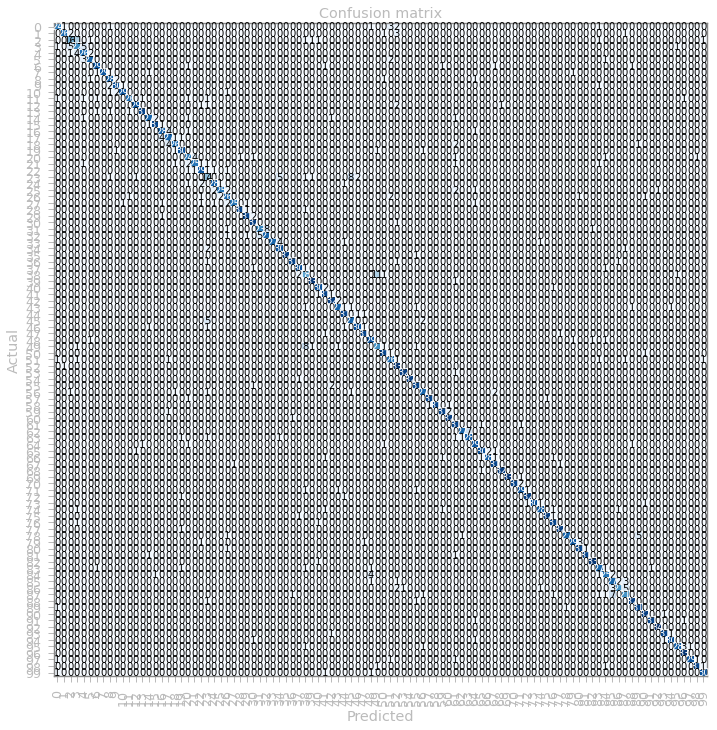

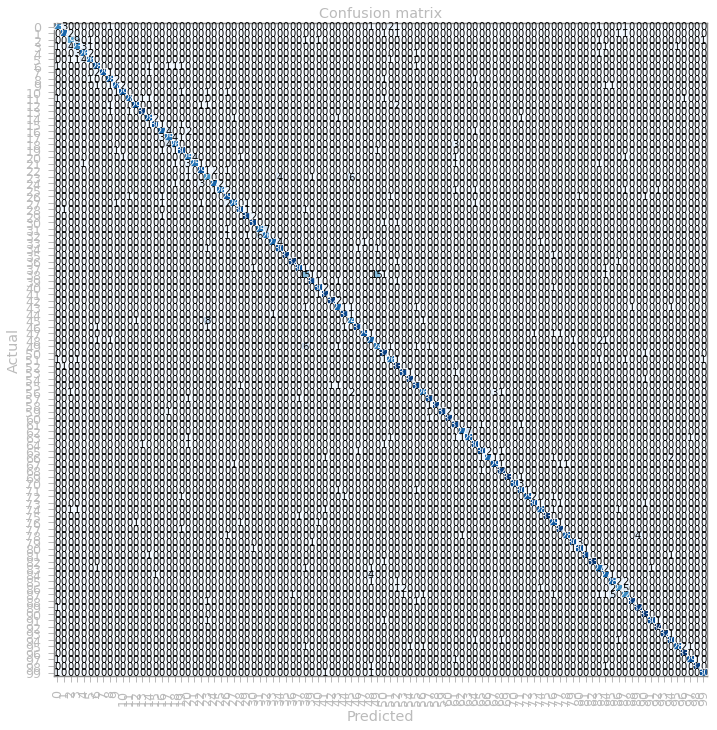

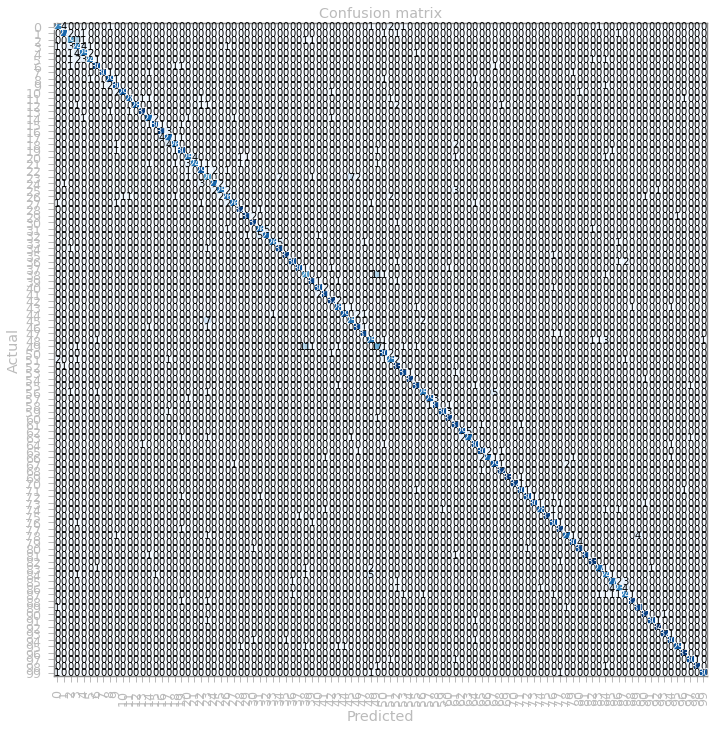

In [36]:
# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):     
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedSCELossFlat(num_classes=num_classes, alpha = 0.1, beta = 1.0, delta=delta, reduction='mean')   
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples,                                               min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))    
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            acc.append(tta_acc)
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
            inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         

In [37]:
# err = {}
print(err)

{0: (1.2299385030748455, 14.791476726531982), 3: (4.889755512224392, 13.951396942138672), 6: (8.30958452077396, 13.591361045837402), 9: (11.519424028798564, 13.771378993988037), 12: (14.84925753712314, 13.201320171356201), 15: (1.3349332533373337, 12.841284275054932), 18: (4.964751762411879, 12.631261348724365), 21: (8.08459577021149, 12.871289253234863), 24: (11.069446527673621, 13.291329145431519), 27: (13.784310784460773, 13.17131519317627), 30: (1.2899355032248372, 13.051307201385498)}


In [38]:
for i in range(len(accs)):
    print(f'acc:{accs[i]}, delta:{deltas[i]}')

acc:0.8520852327346802, delta:0.05197792270443983
acc:0.8604860305786133, delta:0.18578620636934853
acc:0.864086389541626, delta:0.24863047384206832
acc:0.8622862100601196, delta:0.21650635094610968
acc:0.867986798286438, delta:0.10168416076895001
acc:0.8715871572494507, delta:0.05197792270443983
acc:0.8736873865127563, delta:0.18578620636934853
acc:0.8712871074676514, delta:0.24863047384206832
acc:0.8670867085456848, delta:0.21650635094610968
acc:0.8682868480682373, delta:0.10168416076895001
acc:0.869486927986145, delta:0.05197792270443983


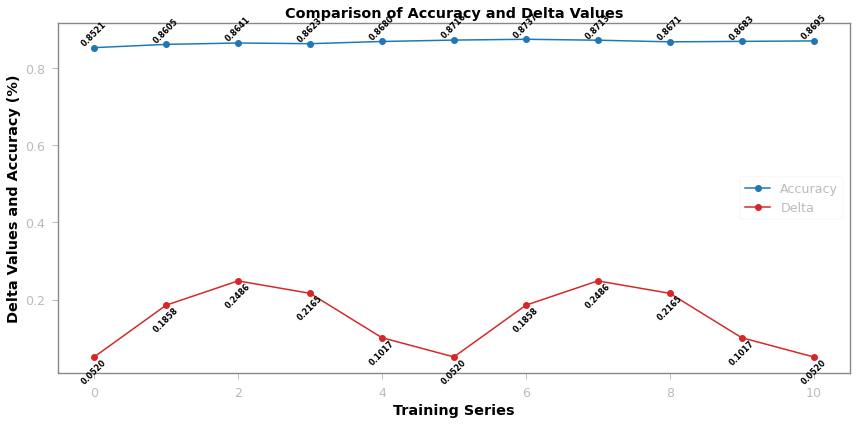

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 90 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6577


Better model found at epoch 0 with accuracy value: 0.9558935165405273.


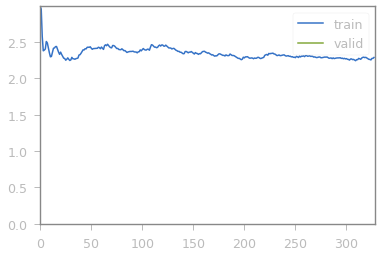

************Round:  0
TTA Accuracy:0.8691869378089905
cycle 0 Error Rate is [{0: (1.3499325033748288, 13.081306219100952)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 87 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6490


Better model found at epoch 0 with accuracy value: 0.9607087969779968.


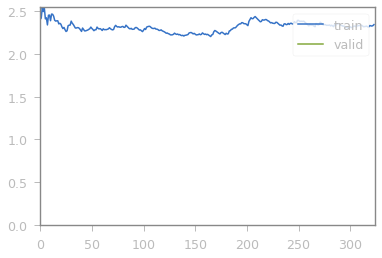

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 77 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6413


Better model found at epoch 0 with accuracy value: 0.9656786322593689.


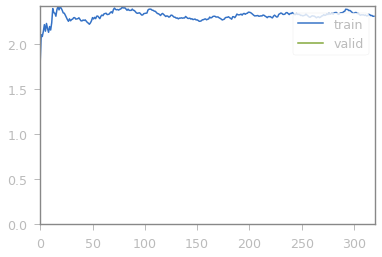

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 76 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6337


Better model found at epoch 0 with accuracy value: 0.9621152281761169.


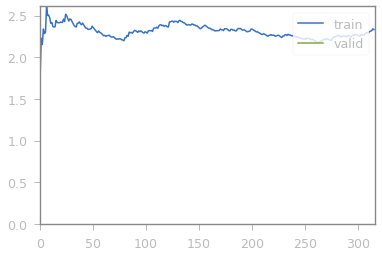

************Round:  3
TTA Accuracy:0.8670867085456848
cycle 0 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 70 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6267


Better model found at epoch 0 with accuracy value: 0.9616919159889221.


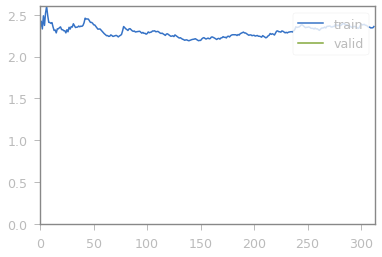

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 71 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6196


Better model found at epoch 0 with accuracy value: 0.9515738487243652.


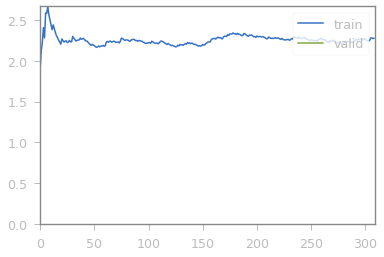

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 62 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6134


Better model found at epoch 0 with accuracy value: 0.9641109108924866.


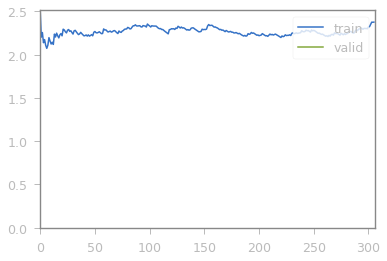

************Round:  6
TTA Accuracy:0.8658865690231323
cycle 0 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 71 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6063


Better model found at epoch 0 with accuracy value: 0.9727723002433777.


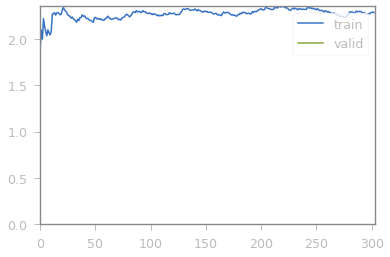

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 62 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6001


Better model found at epoch 0 with accuracy value: 0.9633333086967468.


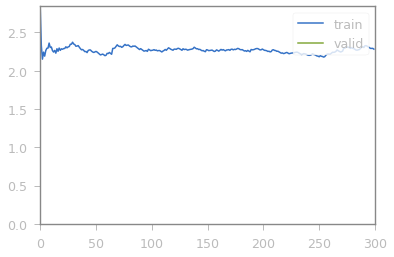

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 68 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5933


Better model found at epoch 0 with accuracy value: 0.9704890251159668.


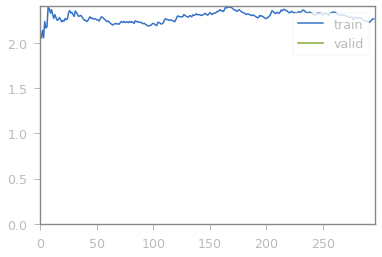

************Round:  9
TTA Accuracy:0.8655865788459778
cycle 0 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 48
Min probability = 0.6646153846153847
Dropped 68 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5865


Better model found at epoch 0 with accuracy value: 0.9676044583320618.


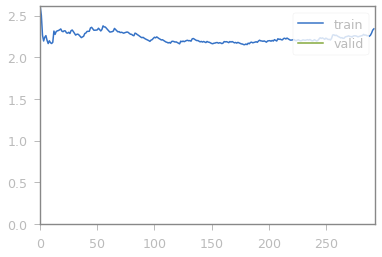

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 64
Min frequency is 48
Min probability = 0.675
Dropped 69 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5796


Better model found at epoch 0 with accuracy value: 0.970664381980896.


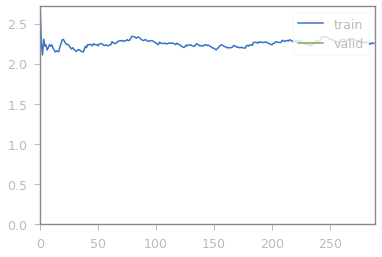

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 64
Min frequency is 48
Min probability = 0.675
Dropped 70 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5726


Better model found at epoch 0 with accuracy value: 0.9703056812286377.


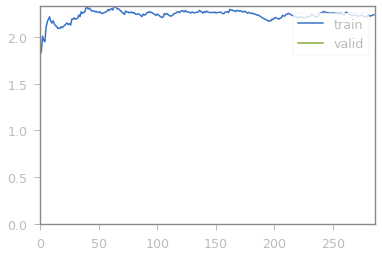

************Round:  12
TTA Accuracy:0.8673867583274841
cycle 0 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 48
Min probability = 0.675
Dropped 57 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5669


Better model found at epoch 0 with accuracy value: 0.9691085815429688.


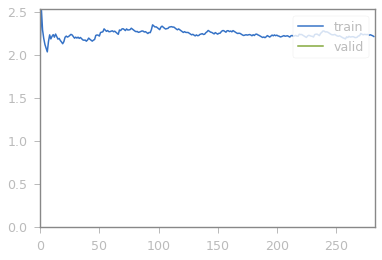

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 64
Min frequency is 47
Min probability = 0.6609375000000001
Dropped 69 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5600


Better model found at epoch 0 with accuracy value: 0.9607142806053162.


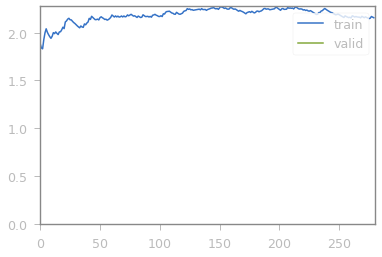

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


Better model found at epoch 0 with accuracy value: 0.9619771838188171.


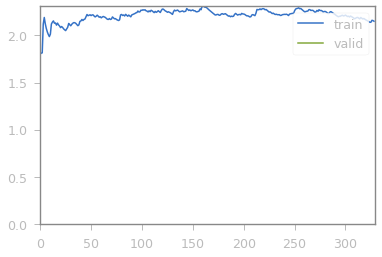

************Round:  0
TTA Accuracy:0.8643864393234253
cycle 1 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 88 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6491


Better model found at epoch 0 with accuracy value: 0.9661017060279846.


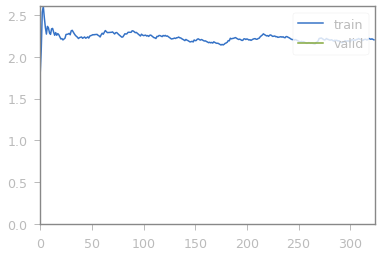

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 78 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6413


Better model found at epoch 0 with accuracy value: 0.9570983052253723.


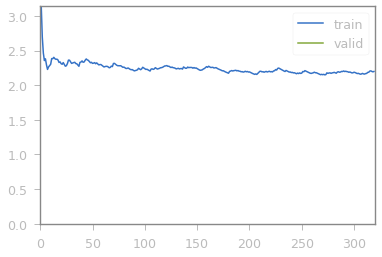

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 80 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6333


Better model found at epoch 0 with accuracy value: 0.9660347700119019.


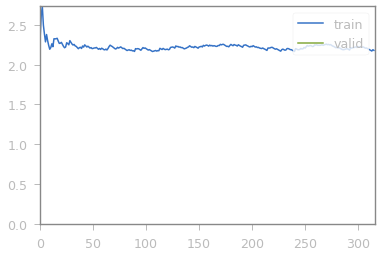

************Round:  3
TTA Accuracy:0.8688868880271912
cycle 1 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 73 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6260


Better model found at epoch 0 with accuracy value: 0.9648562073707581.


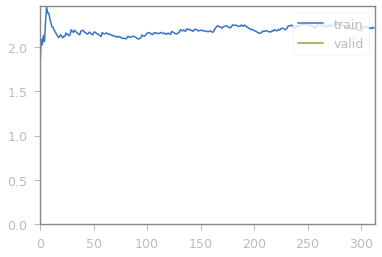

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 84 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6176


Better model found at epoch 0 with accuracy value: 0.9757084846496582.


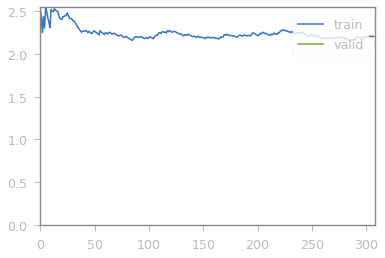

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 71 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6105


Better model found at epoch 0 with accuracy value: 0.9696969985961914.


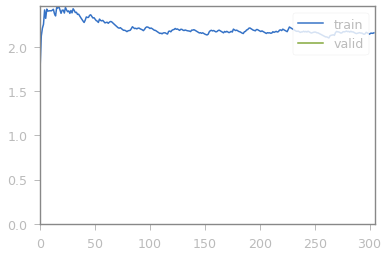

************Round:  6
TTA Accuracy:0.8646864891052246
cycle 1 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884), 21: (8.429578521073944, 13.531351089477539)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 72 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6033


Better model found at epoch 0 with accuracy value: 0.9693200588226318.


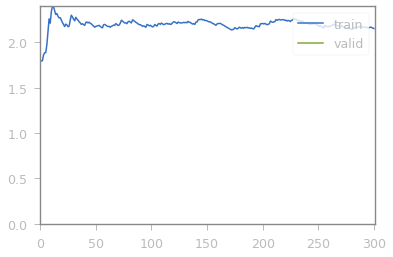

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 53
Min probability = 0.7227272727272727
Dropped 62 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5971


Better model found at epoch 0 with accuracy value: 0.9748743772506714.


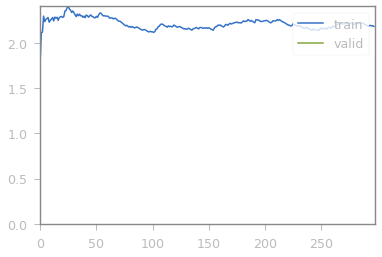

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 51
Min probability = 0.6954545454545454
Dropped 57 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5914


Better model found at epoch 0 with accuracy value: 0.9720812439918518.


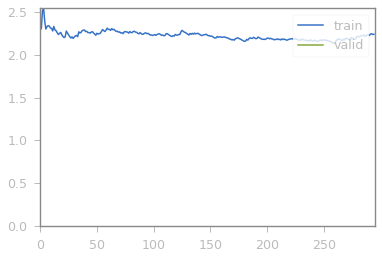

************Round:  9
TTA Accuracy:0.8676867485046387
cycle 1 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884), 21: (8.429578521073944, 13.531351089477539), 24: (11.294435278236092, 13.231325149536133)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 49
Min probability = 0.6784615384615384
Dropped 69 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5845


Better model found at epoch 0 with accuracy value: 0.9734815955162048.


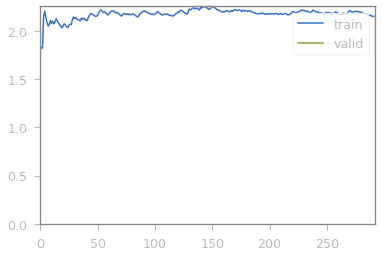

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 65
Min frequency is 48
Min probability = 0.6646153846153847
Dropped 72 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5773


Better model found at epoch 0 with accuracy value: 0.9722703695297241.


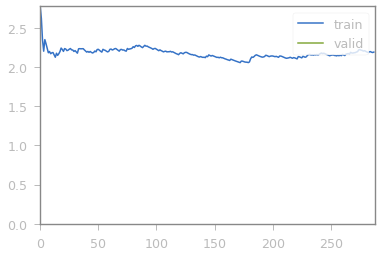

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 65
Min frequency is 46
Min probability = 0.6369230769230769
Dropped 65 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5708


Better model found at epoch 0 with accuracy value: 0.9728308320045471.


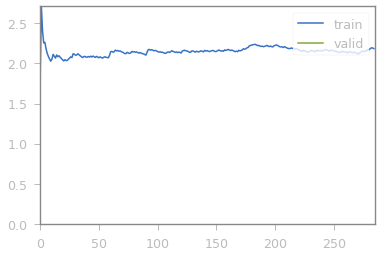

************Round:  12
TTA Accuracy:0.866486668586731
cycle 1 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884), 21: (8.429578521073944, 13.531351089477539), 24: (11.294435278236092, 13.231325149536133), 27: (14.384280785960701, 13.351333141326904)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 65
Min frequency is 43
Min probability = 0.5953846153846154
Dropped 55 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5653


Better model found at epoch 0 with accuracy value: 0.9681416153907776.


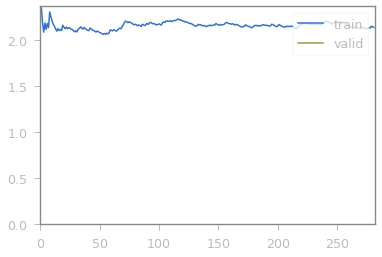

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 64
Min frequency is 41
Min probability = 0.5765625
Dropped 56 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5597


Better model found at epoch 0 with accuracy value: 0.9714030623435974.


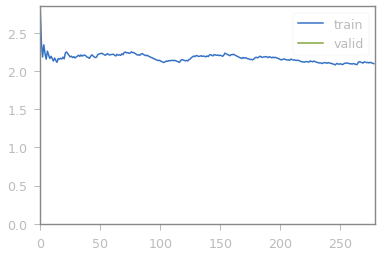

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 86 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6581


Better model found at epoch 0 with accuracy value: 0.9779635071754456.


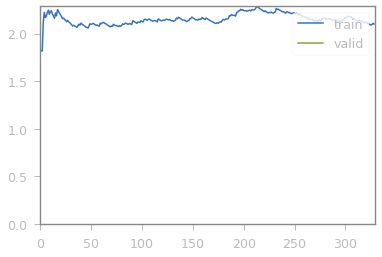

************Round:  0
TTA Accuracy:0.8610861301422119
cycle 2 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884), 21: (8.429578521073944, 13.531351089477539), 24: (11.294435278236092, 13.231325149536133), 27: (14.384280785960701, 13.351333141326904), 30: (1.2899355032248372, 13.891386985778809)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 88 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6493


Better model found at epoch 0 with accuracy value: 0.9791987538337708.


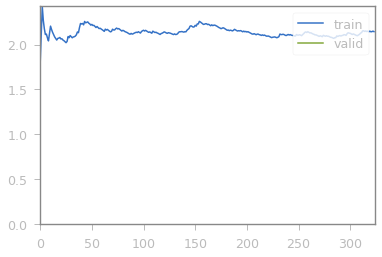

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 84 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6409


Better model found at epoch 0 with accuracy value: 0.9781420826911926.


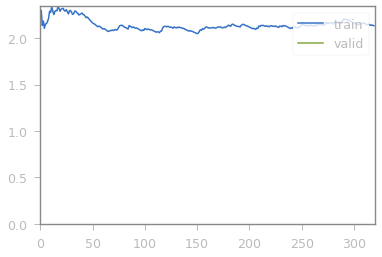

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 81 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6328


Better model found at epoch 0 with accuracy value: 0.9707509875297546.


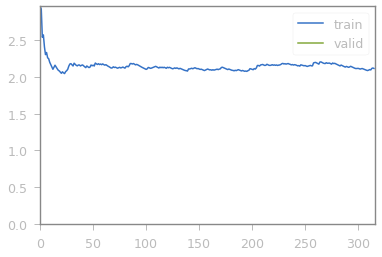

************Round:  3
TTA Accuracy:0.8637863993644714
cycle 2 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884), 21: (8.429578521073944, 13.531351089477539), 24: (11.294435278236092, 13.231325149536133), 27: (14.384280785960701, 13.351333141326904), 30: (1.2899355032248372, 13.891386985778809), 33: (5.0847457627118615, 13.621360063552856)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 77 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6251


Better model found at epoch 0 with accuracy value: 0.9703999757766724.


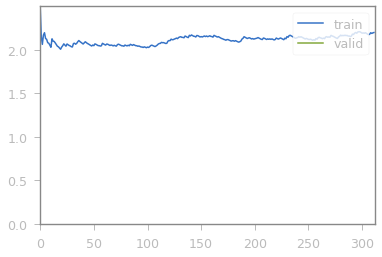

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 73 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6178


Better model found at epoch 0 with accuracy value: 0.9732793569564819.


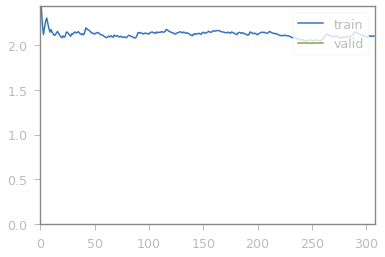

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 83 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6095


Better model found at epoch 0 with accuracy value: 0.9794914126396179.


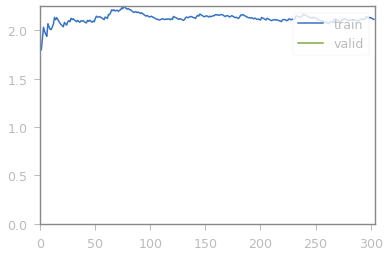

************Round:  6
TTA Accuracy:0.8634863495826721
cycle 2 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884), 21: (8.429578521073944, 13.531351089477539), 24: (11.294435278236092, 13.231325149536133), 27: (14.384280785960701, 13.351333141326904), 30: (1.2899355032248372, 13.891386985778809), 33: (5.0847457627118615, 13.621360063552856), 36: (8.579571021448928, 13.651365041732788)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 65 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6030


Better model found at epoch 0 with accuracy value: 0.9776119589805603.


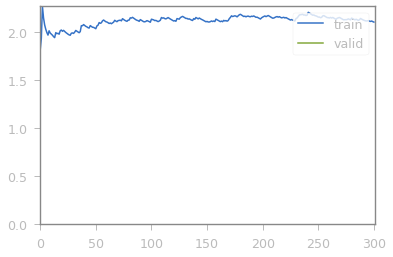

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 70 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5960


Better model found at epoch 0 with accuracy value: 0.9731543660163879.


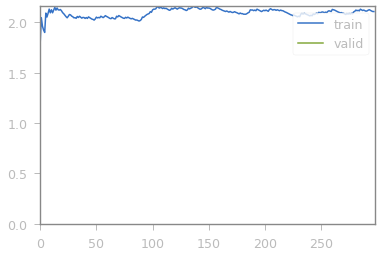

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 41
Min probability = 0.5590909090909091
Dropped 50 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5910


Better model found at epoch 0 with accuracy value: 0.9847715497016907.


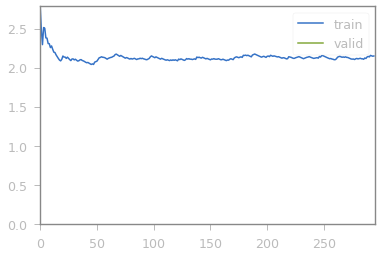

************Round:  9
TTA Accuracy:0.862586259841919
cycle 2 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884), 21: (8.429578521073944, 13.531351089477539), 24: (11.294435278236092, 13.231325149536133), 27: (14.384280785960701, 13.351333141326904), 30: (1.2899355032248372, 13.891386985778809), 33: (5.0847457627118615, 13.621360063552856), 36: (8.579571021448928, 13.651365041732788), 39: (11.354432278386085, 13.741374015808105)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 66
Min frequency is 41
Min probability = 0.5590909090909091
Dropped 54 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5856


Better model found at epoch 0 with accuracy value: 0.9735268950462341.


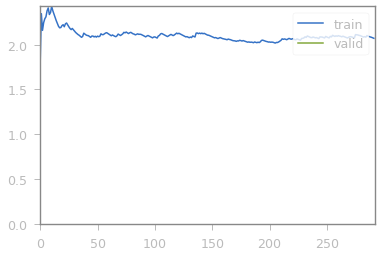

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 40
Min probability = 0.5454545454545455
Dropped 44 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5812


Better model found at epoch 0 with accuracy value: 0.9802065491676331.


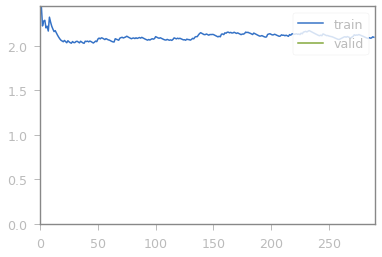

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 65
Min frequency is 40
Min probability = 0.5538461538461539
Dropped 47 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5765


Better model found at epoch 0 with accuracy value: 0.9731135964393616.


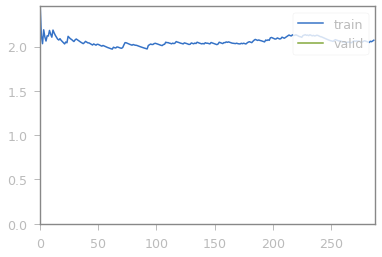

************Round:  12
TTA Accuracy:0.8673867583274841
cycle 2 Error Rate is [{0: (1.3499325033748288, 13.081306219100952), 3: (4.949752512374383, 13.291329145431519), 6: (7.9946002699864955, 13.411343097686768), 9: (11.009449527523628, 13.441342115402222), 12: (14.114294285285734, 13.261324167251587), 15: (1.3199340032998386, 13.56135606765747), 18: (5.009749512524375, 13.111311197280884), 21: (8.429578521073944, 13.531351089477539), 24: (11.294435278236092, 13.231325149536133), 27: (14.384280785960701, 13.351333141326904), 30: (1.2899355032248372, 13.891386985778809), 33: (5.0847457627118615, 13.621360063552856), 36: (8.579571021448928, 13.651365041732788), 39: (11.354432278386085, 13.741374015808105), 42: (13.529323533823312, 13.261324167251587)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 63
Min frequency is 40
Min probability = 0.5714285714285714
Dropped 49 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5716


Better model found at epoch 0 with accuracy value: 0.9798775315284729.


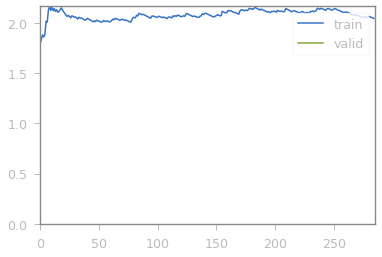

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 38
Min probability = 0.5428571428571428
Dropped 57 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5659


Better model found at epoch 0 with accuracy value: 0.9805482029914856.


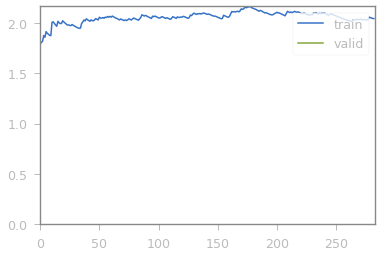

In [29]:
delta_max = 0.50
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedSCELossFlat(num_classes = num_classes, alpha = 0.1, beta = 1.0, delta=delta, reduction='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

    
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         

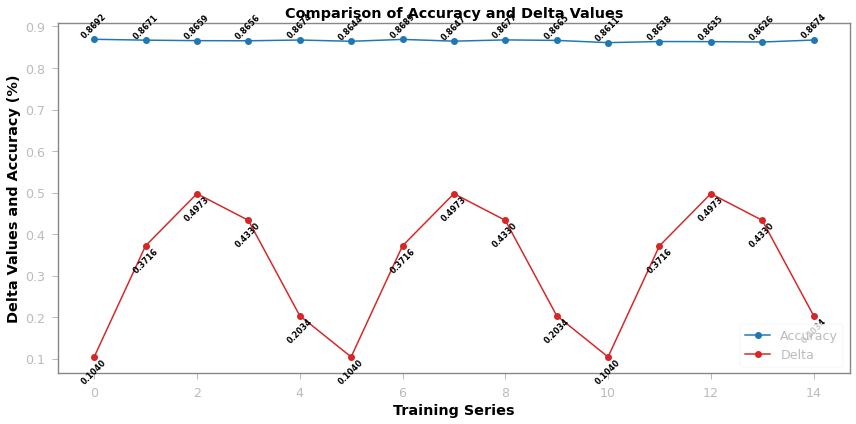

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
